In [4]:
import numpy as np
import pandas as pd
import cudf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Stel de data in
X_tr = pd.read_csv('alle_kranten_X_train.csv')
X_te = pd.read_csv('alle_kranten_X_test.csv')
y_tr = pd.read_csv('alle_kranten_y_train.csv')
y_te = pd.read_csv('alle_kranten_y_test.csv')


# Maak een scaler object
scaler = StandardScaler()

# Schaal de data
X_tr_scaled = scaler.fit_transform(X_tr_clipped)
X_te_scaled = scaler.transform(X_te_clipped)
y_tr_scaled = scaler.fit_transform(y_tr_clipped.values.reshape(-1, 1))
y_te_scaled = scaler.transform(y_te_clipped.values.reshape(-1, 1))

# Log-transformatie
y_log = np.log1p(y_tr_scaled)

# Initialiseer en train het model
model = XGBRegressor(random_state=42)
model.fit(X_tr_scaled, y_log)

# Maak voorspellingen
y_pred_log = model.predict(X_te_scaled)

# Beperk de voorspellingen na exp1 om overflows te voorkomen
y_pred_log = np.clip(y_pred_log, -500, 500)
y_pred = np.expm1(y_pred_log)

# Evaluatie van het model
mse = mean_squared_error(np.expm1(y_te_scaled), y_pred)
rmse = mse ** 0.5

# Print de resultaten
print(f"RMSE na log-transformatie: {rmse}")

RMSE na log-transformatie: 602.5378555399827


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Laad de data
X_tr = pd.read_csv('alle_kranten_X_train.csv')
X_te = pd.read_csv('alle_kranten_X_test.csv')
y_tr = pd.read_csv('alle_kranten_y_train.csv')
y_te = pd.read_csv('alle_kranten_y_test.csv')

# Clip extreme waarden om outliers te vermijden
X_tr_clipped = np.clip(X_tr, -500, 500)
X_te_clipped = np.clip(X_te, -500, 500)
y_tr_clipped = np.clip(y_tr, 1, None) 
y_te_clipped = np.clip(y_te, 1, None)

# scaler object
scaler = StandardScaler()

# Schaal features
X_tr_scaled = scaler.fit_transform(X_tr_clipped)
X_te_scaled = scaler.transform(X_te_clipped)

# Log-transformatie toepassen op de target
y_tr_log = np.log1p(y_tr_clipped)  # log(1 + y) om problemen met nulwaarden te vermijden
y_te_log = np.log1p(y_te_clipped)

# Gewicht geven aan hogere waarden, maar in log-schaal
weights = np.where(y_tr_log > np.log1p(300), 2.0, 1.0)  # 2x gewicht voor grotere waarden

# Initialiseren en train model met gewichten
model = XGBRegressor(random_state=42)
model.fit(X_tr_scaled, y_tr_log.values.ravel(), sample_weight=weights)

# Maak voorspellingen in de log-schaal
y_pred_log = model.predict(X_te_scaled)

# Terugschalen door exponentiële transformatie
y_pred = np.expm1(y_pred_log)  # exp(y) - 1 om de oorspronkelijke schaal terug te krijgen
y_te_original = np.expm1(y_te_log)

# Evaluatie van het model
mse = mean_squared_error(y_te_original, y_pred)
rmse = mse ** 0.5
print(f"RMSE met log-transformatie en gewichten: {rmse}")

RMSE met log-transformatie en gewichten: 45.684031164945594


In [ ]:
from sklearn.svm import SVR

# Initialiseer en train het model
svr_model = SVR(kernel='rbf', C=10, gamma=0.1)
svr_model.fit(X_tr_scaled, y_tr_scaled.ravel())  # Zorg ervoor dat y een 1D-array is

# Maak voorspellingen
y_pred_svr = svr_model.predict(X_te_scaled)

# Bereken RMSE
mse_svr = mean_squared_error(y_te_scaled, y_pred_svr)
rmse_svr = mse_svr ** 0.5
print(f"RMSE SVR: {rmse_svr}")


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 500, 1000],  # Meer bomen kan helpen
    'learning_rate': [0.01, 0.05, 0.1],  # Kleinere learning rate met meer bomen
    'max_depth': [3, 5, 7],  # Beperkt de complexiteit van de bomen
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.7, 1.0] 
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_search.fit(X_tr_scaled, y_tr_log.values.ravel(), sample_weight=weights)

# Beste model gebruiken
best_model = grid_search.best_estimator_
y_pred_log = best_model.predict(X_te_scaled)
y_pred = np.expm1(y_pred_log)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   6.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   9.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=  10.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=  12.0s
[CV] END 

In [13]:
print("Beste hyperparameters:", grid_search.best_params_)


Beste hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 1.0}


In [20]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Beste hyperparameters van GridSearchCV
best_model = XGBRegressor(
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=1000,
    subsample=1.0,
    random_state=42
)

# Model trainen
best_model.fit(X_tr_scaled, y_tr_log.values.ravel(), sample_weight=weights)

# Voorspellingen maken
y_pred_log = best_model.predict(X_te_scaled)  # Log-schaal voorspellingen
y_pred = np.expm1(y_pred_log)  # Terug naar originele schaal

# RMSE berekenen
mse = mean_squared_error(y_te_clipped, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_te_clipped, y_pred)
print(f"RMSE met de beste hyperparameters: {rmse}")
print(f"R²-score: {r2}")


RMSE met de beste hyperparameters: 45.188366241860614
R²-score: 0.2989837277822086


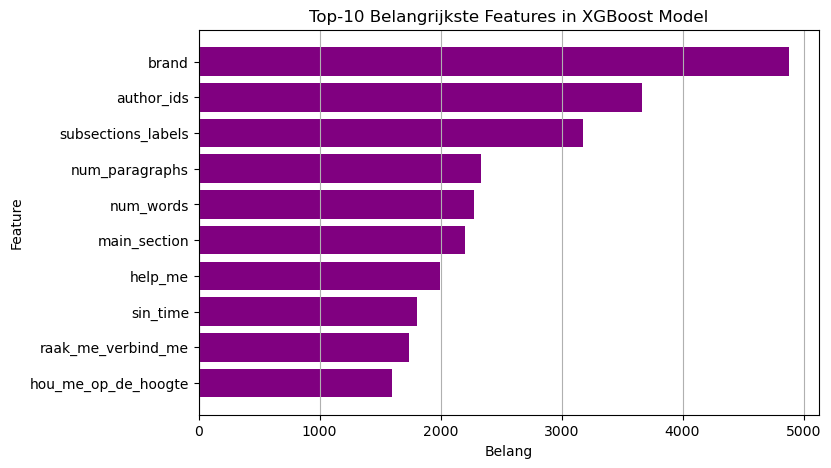

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances ophalen
feature_importance = best_model.get_booster().get_score(importance_type='weight')

# Koppel de echte feature namen
feature_map = {f"f{i}": col for i, col in enumerate(X_tr.columns)}

# Vervang de f0, f1, ... door de echte namen
feature_importance_named = {feature_map[k]: v for k, v in feature_importance.items()}

# Omzetten naar een dataframe
feature_df = pd.DataFrame(
    list(feature_importance_named.items()), columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

# Top 10 belangrijkste features
top_features = feature_df.head(10)

# Plot de feature importances
plt.figure(figsize=(8, 5))
plt.barh(top_features["Feature"], top_features["Importance"], color="purple")
plt.xlabel("Belang")
plt.ylabel("Feature")
plt.title("Top-10 Belangrijkste Features in XGBoost Model")
plt.gca().invert_yaxis()  # Omhoog laten lopen
plt.grid(True, axis="x")
plt.show()


In [21]:
from sklearn.decomposition import PCA
import numpy as np

# PCA met 95% uitgelegde variantie (automatische selectie van componenten)
pca = PCA(n_components=0.95)  # Behoudt 95% van de variantie

# PCA toepassen op trainings- en testdata
X_tr_pca = pca.fit_transform(X_tr_scaled)
X_te_pca = pca.transform(X_te_scaled)

# Hoeveel features blijven er over?
print(f"Aantal PCA-componenten: {X_tr_pca.shape[1]}")


Aantal PCA-componenten: 138


In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Model met dezelfde hyperparameters trainen
best_model_pca = XGBRegressor(
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=1000,
    subsample=1.0,
    random_state=42
)

# Model trainen met PCA-getransformeerde features
best_model_pca.fit(X_tr_pca, y_tr_log.values.ravel(), sample_weight=weights)

# Voorspellingen maken
y_pred_log_pca = best_model_pca.predict(X_te_pca)  # Log-schaal voorspellingen
y_pred_pca = np.expm1(y_pred_log_pca)  # Terug naar originele schaal

# Evaluatie
mse_pca = mean_squared_error(y_te_clipped, y_pred_pca)
rmse_pca = np.sqrt(mse_pca)
r2_pca = r2_score(y_te_clipped, y_pred_pca)

print(f"RMSE met PCA: {rmse_pca}")
print(f"R²-score met PCA: {r2_pca}")


RMSE met PCA: 45.53946923540513
R²-score met PCA: 0.2880479443419406
